In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [ ]:
# load mtx files and save all raw data as h5ad

In [3]:
def load_adata(outfolder, 
               # subfolder = 'filtered'
               subfolder = 'raw'
              ):
    #load matrix
    if subfolder == 'filtered':
        ad = sc.read_mtx("rawdata/%s/GeneFull/%s/matrix.mtx.gz" %(outfolder, subfolder))
    else:
        ad = sc.read_mtx("rawdata/%s/GeneFull/%s/UniqueAndMult-EM.mtx.gz" %(outfolder, subfolder))
        # ad = sc.read_mtx("rawdata/%s/GeneFull/%s/matrix.mtx.gz" %(outfolder, subfolder))
    ad = ad.transpose()
    #load genes
    features = pd.read_table("rawdata/%s/GeneFull/%s/features.tsv"%(outfolder, subfolder), names = ['gene_ids','gene_ids2','type'])
    ad.var['gene_ids'] = features.gene_ids.values
    ad.var.index = list(features.gene_ids.values)
    ad.var['feature_types'] = "Gene Expression"
    #load barcodes
    bc = pd.read_table("rawdata/%s/GeneFull/%s/barcodes.tsv"%(outfolder, subfolder), names = ['bc'])
    ad.obs['barcode'] = bc.bc.values
    ad.obs.index = list(bc.bc.values)
    return ad

In [22]:
adata = load_adata("elicitedSolo.out")
adata.write_h5ad("raw_adata/elicitedSolo.h5ad")
adata = load_adata("matureSolo.out")
adata.write_h5ad("raw_adata/matureSolo.h5ad")
adata = load_adata("youngSolo.out")
adata.write_h5ad("raw_adata/youngSolo.h5ad")

cellbender used to remove ambient RNA in separate conda environment

setup:
conda create -n cellbender python=3.7
conda activate cellbender


In [20]:
#print commands for cellbender
for s in ["mature", "elicited", "young"]:
    cmd = "cellbender remove-background --input raw_adata/%sSolo.h5ad --output clean_adata/%s_denoised.h5ad --total-droplets-included 50000 --cuda" %(s,s)
    print (cmd)

cellbender remove-background --input raw_adata/matureSolo.h5ad --output clean_adata/mature_denoised.h5ad --total-droplets-included 50000 --cuda
cellbender remove-background --input raw_adata/elicitedSolo.h5ad --output clean_adata/elicited_denoised.h5ad --total-droplets-included 50000 --cuda
cellbender remove-background --input raw_adata/youngSolo.h5ad --output clean_adata/young_denoised.h5ad --total-droplets-included 50000 --cuda


In [ ]:
# adata = sc.read_10x_mtx("rawdata/matureSolo.out/GeneFull/raw2/")

In [7]:
metrics = []
for file in [x for x in os.listdir('clean_adata/') if x.endswith('metrics.csv')]:
    _ = pd.read_csv('clean_adata/' + file,
                header = None, names = ['Metric', 'Value']).set_index('Metric').T

    _['File'] = file
    metrics.append(_)
    
metrics = pd.concat(metrics).reset_index()

In [8]:
metrics

Metric,index,total_raw_counts,total_output_counts,total_counts_removed,fraction_counts_removed,total_raw_counts_in_cells,total_counts_removed_from_cells,fraction_counts_removed_from_cells,average_counts_removed_per_cell,target_fpr,expected_cells,found_cells,output_average_counts_per_cell,ratio_of_found_cells_to_expected_cells,found_empties,fraction_of_analyzed_droplets_that_are_nonempty,convergence_indicator,overall_change_in_train_elbo,File
0,Value,42570688.0,4.192189e+07,648795.024,0.015,42570652.0,648759.024,0.015,92.534,0.01,3450.0,7011.0,5979.446,2.032,42989.0,0.140,1.254,326.965,mature_denoised_metrics.csv
1,Value,37310260.0,3.533459e+07,1975666.956,0.053,37310248.0,1975654.956,0.053,352.859,0.01,1460.0,5599.0,6310.876,3.835,44401.0,0.112,0.191,387.859,young_denoised_metrics.csv
2,Value,97025048.0,9.484462e+07,2180428.988,0.022,97024888.0,2180268.988,0.022,187.051,0.01,4633.0,11656.0,8136.978,2.516,38344.0,0.233,0.884,1191.730,elicited_denoised_metrics.csv


# QC

In [10]:
adatas = [x for x in os.listdir('clean_adata/') if x.endswith('filtered.h5')]

In [11]:
adatas

['elicited_denoised_filtered.h5',
 'young_denoised_filtered.h5',
 'mature_denoised_filtered.h5']

In [12]:
def load_it(adata):
    samp = adata.split('_')[0]
    adata = sc.read_10x_h5('clean_adata/' + adata)
    adata.obs['Sample'] = samp
    # adata.obs.index = adata.obs.index + samp
    return adata

In [13]:
adatas = [load_it(ad) for ad in adatas]

In [15]:
# mitochondrial and chloroplast genes 

chloroplast_genes = list(set([
    'ctg15135_gene.1','ctg6280_gene.1','ctg15135_gene.3','ctg9769_gene.1','ctg3040_gene.26','ctg15135_gene.4','ctg51947_gene.2',
                             ]))

mito_genes = list(set([
    'ctg27936_gene.1','ctg20805_gene.6',
'ctg9475_gene.2','ctg28563_gene.1','ctg9475_gene.1','ctg28563_gene.2','ctg19808_gene.1','ctg14084_gene.2','ctg20805_gene.1','ctg32734_gene.1','ctg40267_gene.1','ctg32734_gene.2',
'ctg40267_gene.2','ctg28972_gene.1','ctg35099_gene.1','ctg44235_gene.1','ctg14084_gene.1','ctg28972_gene.2','ctg15046_gene.1','ctg28972_gene.4','ctg41401_gene.1','ctg28972_gene.5',
'ctg425_gene.2','ctg7827_gene.2','ctg7827_gene.2','ctg29557_gene.2','ctg33445_gene.1','ctg34521_gene.1','ctg51816_gene.3','ctg7827_gene.3','ctg1173_gene.3','ctg16564_gene.1',
]))
len(mito_genes)

31

In [16]:
def qc(adata):
    
    #you could also use a whitelist of barcodes from the filtered barcodes for each sample
    sc.pp.filter_cells(adata, min_genes = 200) #if you use the whitelist, you can get rid of this
    
    adata.var["mt"] = adata.var_names.isin(mito_genes)
    # adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["chlr"] = adata.var_names.isin(chloroplast_genes)
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "chlr"], inplace=True, percent_top=[20], log1p=True)

    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_chlr', 
          'log1p_total_counts_chlr',]
    
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [17]:
adatas = [qc(ad) for ad in adatas]


In [18]:
df = pd.concat([x.obs for x in adatas])
df = df.sort_values('Sample')


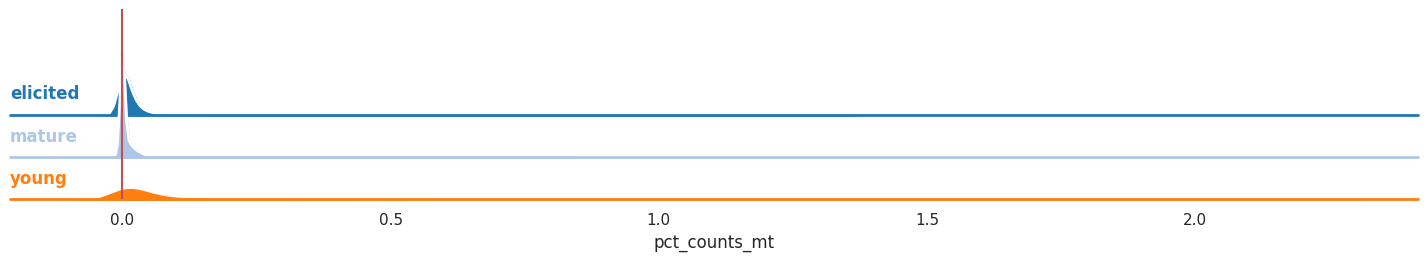

In [31]:
#examine distribution of various metrics

value = "pct_counts_mt"
# value = "pct_counts_chlr"
# value = "n_genes"
# value = 'pct_counts_in_top_20_genes'
# value = "log1p_total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=1, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

# doublet detection

In [23]:
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

In [80]:
a = df[df.Sample == 'young'].log1p_total_counts
b = df[df.Sample == 'young'].pct_counts_in_top_20_genes


Text(0, 0.5, 'log1p_n_genes_by_counts')

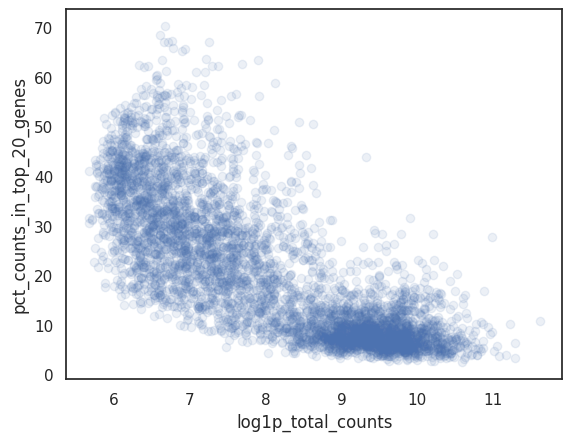

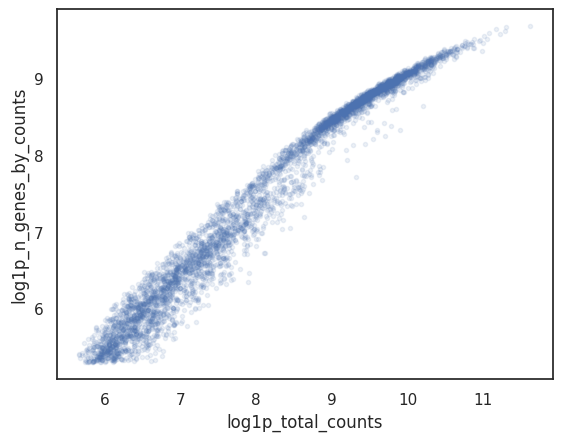

In [81]:
plt.plot(a,b,"o", alpha = 0.1)
plt.xlabel("log1p_total_counts")
plt.ylabel("pct_counts_in_top_20_genes")

plt.figure()
plt.plot(a,df[df.Sample == 'young'].log1p_n_genes_by_counts,
         ".", alpha = 0.1)
plt.xlabel("log1p_total_counts")
plt.ylabel("log1p_n_genes_by_counts")


In [89]:
a = df[df.Sample == 'elicited'].log1p_n_genes_by_counts


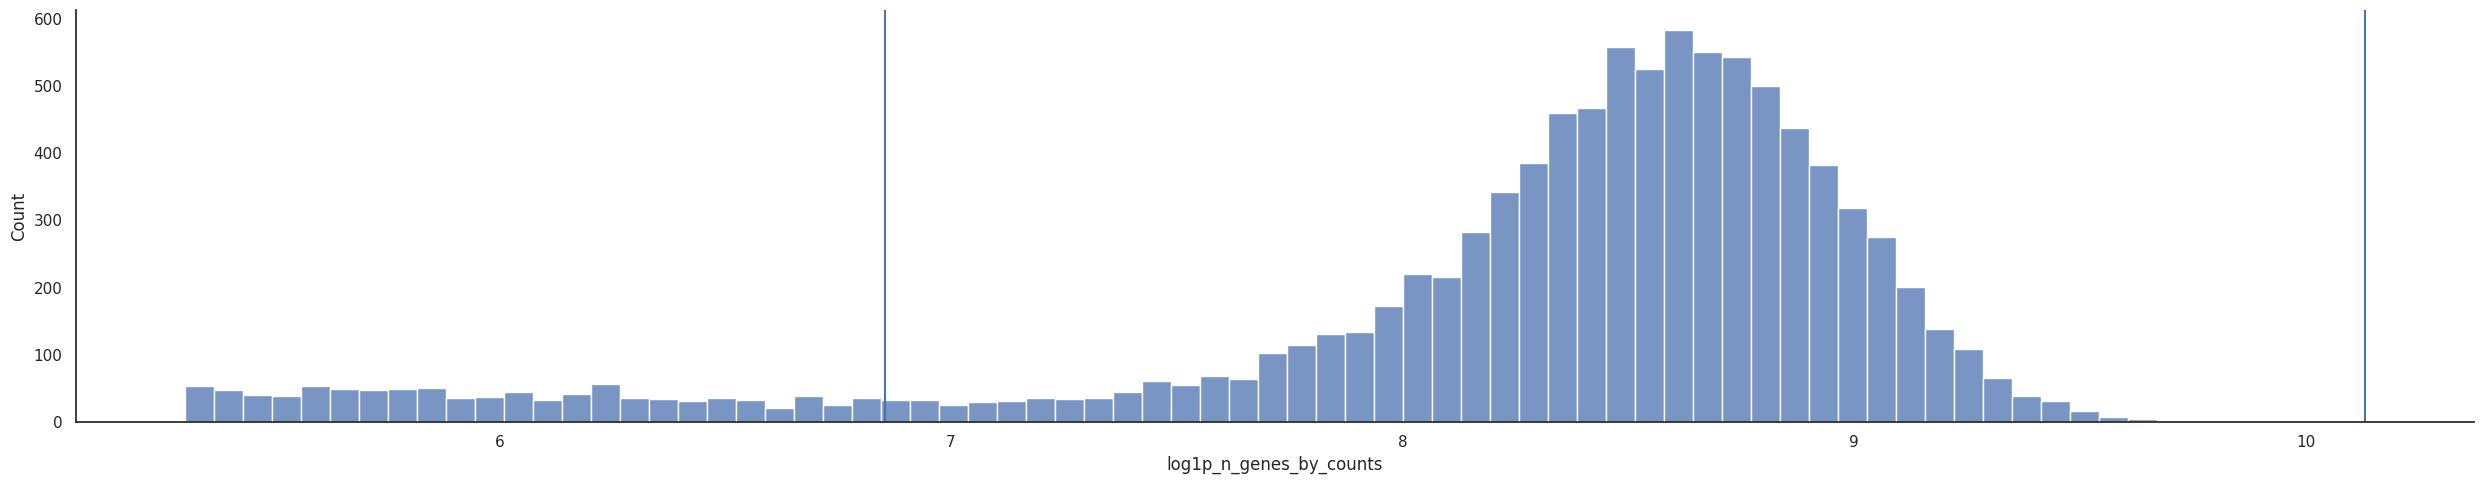

In [90]:
ax = sns.displot(a, aspect = 5)

plt.axvline(np.median(a) - 6 * mad(a))
plt.axvline(np.median(a) + 6 * mad(a))

plt.show()

In [34]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

In [27]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

In [82]:
def pp_test(adata):
    adata = adata[adata.obs.pct_counts_in_top_20_genes < 25] #you can lower this based on the overal distribution of your dataset
    # adata = adata[adata.obs.pct_counts_mt < 1] #you can lower this based on the overal distribution of your dataset
    # adata = adata[adata.obs.pct_counts_chlr < 15] 
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 6) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 6) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 6) #+\
            # mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)
    print (sum(bool_vector), "cells removed")

    # doublets = clf.fit(adata.X).predict(p_thresh=1e-15, voter_thresh=0.5)
    # doublet_score = clf.doublet_score()

    # adata.obs["doublet"] = doublets
    # adata.obs["doublet_score"] = doublet_score

    # adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    # adata = adata[adata.obs.doublet == 0]

    # return adata

In [83]:
 [pp_test(ad) for ad in adatas]

725 cells removed
0 cells removed
325 cells removed


[None, None, None]

In [86]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_in_top_20_genes < 25] #you can lower this based on the overal distribution of your dataset
    # adata = adata[adata.obs.pct_counts_mt < 1] #you can lower this based on the overal distribution of your dataset
    # adata = adata[adata.obs.pct_counts_chlr < 15] 
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 6) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 6) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 6) #+\
            # mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    doublets = clf.fit(adata.X).predict(p_thresh=1e-15, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    adata.obs["doublet"] = doublets
    adata.obs["doublet_score"] = doublet_score

    adata.uns['doublets_removed'] = adata.obs.doublet.sum()
    adata = adata[adata.obs.doublet == 0]

    return adata
    

In [87]:
adatas_pp = [pp(ad) for ad in adatas]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [88]:
for adata in adatas_pp:
    print(len(adata), adata.uns['cells_removed'], adata.uns['doublets_removed'])

8039 571 594.0
3027 0 28.0
6077 308 426.0


In [92]:
#save final preprocessed adata as h5ad files
for adata in adatas_pp:
    s = adata.obs["Sample"].values[0]
    adata.write_h5ad("preprocessed_adata/%s.h5ad"%s)